<h1> Материалы курса "Анализ данных в инфромационной безопасности" </h1>

<h2> Практическое занятие № 5.2 </h2>

<h2> Тема: "Кластеризация пакетов траффика" </h2>

<h2>Автор:</h2>

<p>Русинова Залина</p>
<p>Младший исследователь исследовательского центра UDV Group</p>
<p>zalina.rusinova@udv.group</p>

## Оглавление <a name='toc'></a>
<ol>
<li><a href='#intro'>Описание идеи</a></li>
<li><a href='#load'> Загрузка и подготовка данных</a></li>
<li><a href='#emb'>Получение векторных представлений пакетов</a></li>
</ol>

In [48]:
#!pip install scapy
import scapy
from scapy.all import rdpcap, wrpcap

import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import gensim
from gensim.models import word2vec
from gensim.models import FastText

import collections

### 1. Описание идеи <a name='intro'></a>

В данном примере мы увидим, как можно применять методы обработки естественного языка к данным, которые не являются тестами на естетсвенном языке. Мы применим алгоритмы построения векторных представлений тестов к пакетом сетевого трафика, для того, чтобы разделить пакеты трафика на группы с одинаковыми стеками протоколов.

### 2. Загрузка и подготовка данных <a name='load'></a>

***Набор данных***
[Capture files from 4SICS Geek Lounge](https://www.netresec.com/?page=PCAP4SICS)

Датасет с конференции промышленной кибербезопасности 4SICS. Трафик получен в ICS лаборатории, где есть следующие виды устройств: PLC, RTU (Remote Terminal Unit), серверы, промышленное сетевое оборудование (коммутаторы, межсетевые экраны и т.д.)

In [49]:
filename = './4SICS-GeekLounge-151020.pcap'

Для чтения pcap-файлов и работы с сетевыми пакетами мы будем использовать библиотеку Scapy.

**Scapy** – интерактивная оболочка и программная библиотека для манипулирования сетевыми пакетами на языке программирования Python. 
Scapy использует библиотеку libpcap и может использоваться как сниффер для перехвата и анализа сетевого трафика, так и как конструктор пакетов. Помимо использование стандартных протоколов, в Scapy есть возможность создавать собственные и использовать их при анализе и генерации пакетов

In [50]:
# Функция rdcap - читает сообщения из pcap-файла и создает список из прочитанных сообщений.
packet = rdpcap(filename, count=1)[0]
packet

<Ether  dst=00:07:7c:1a:61:83 src=00:90:e8:27:8c:37 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=59 id=44816 flags= frag=0 ttl=64 proto=udp chksum=0x9a12 src=192.168.88.61 dst=192.168.88.1 |<UDP  sport=949 dport=domain len=39 chksum=0xf45d |<DNS  id=43814 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='time.nist.gov.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

In [51]:
packet.layers()

[scapy.layers.l2.Ether,
 scapy.layers.inet.IP,
 scapy.layers.inet.UDP,
 scapy.layers.dns.DNS]

In [52]:
' '.join([str(byte) for byte in bytes(packet)]) 

'0 7 124 26 97 131 0 144 232 39 140 55 8 0 69 0 0 59 175 16 0 0 64 17 154 18 192 168 88 61 192 168 88 1 3 181 0 53 0 39 244 93 171 38 1 0 0 1 0 0 0 0 0 0 4 116 105 109 101 4 110 105 115 116 3 103 111 118 0 0 1 0 1'

Напишем функцию, которая будет читать сообщения из pcap-файла, преобразовывать сообщения в байтовый формат, удалять байты, которые относятся к протоколам транспортного уровня и ниже, а также формировать списки схем протоколов и метки для каждого пакета рассматриваемого дампа трафика

In [53]:
def load_dumps(filename, count=10000):
    # создать переменную  packets, в которую будут записаны сообщения из pcap файла 
    #(количество сообщений задано переменной count)
    packets = rdpcap(filename, count=count)
    croped_packets = []
    for i in packets:
        packet = i
        if len(i.layers())>1 and scapy.layers.l2.Ether in i.layers():
            packet = packet.payload
            if len(i.layers())>2 and scapy.layers.inet.IP in i.layers():
                packet = packet.payload
                if len(i.layers())>3 and ((scapy.layers.inet.TCP in i.layers()) or (scapy.layers.inet.UDP in i.layers())):
                    packet = packet.payload
        croped_packets.append(packet)
    str_packets = []
    for packet in croped_packets:
        # заполнить список str_packets строками, в которых содержатся байты пакета, соединенные через пробел
        str_packets.append(' '.join([str(byte) for byte in bytes(packet)]))
        
    schemes = list(set([tuple(packet.layers()) for packet in packets]))
    dict_schemes = dict()
    for count, schema in enumerate(schemes):
            dict_schemes[schema] = count
            
    labels = []
    for packet in packets:
        layres = tuple(packet.layers())
        labels.append(dict_schemes[layres])
    
    return str_packets, labels, schemes

In [54]:
%%time
packets_4SICS, labels_4SICS, schemas_4SICS = load_dumps(filename, count=30000)

Wall time: 7.51 s


In [61]:
schemas_4SICS

[(scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.UDP,
  scapy.layers.dns.DNS),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.TCP,
  scapy.packet.Raw,
  scapy.packet.Padding),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.ICMP,
  scapy.layers.inet.IPerror,
  scapy.layers.inet.UDPerror,
  scapy.layers.ntp.NTPHeader),
 (scapy.layers.l2.Ether, scapy.packet.Raw),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.TCP,
  scapy.packet.Padding),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.TCP,
  scapy.packet.Raw),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.UDP,
  scapy.packet.Raw,
  scapy.packet.Padding),
 (scapy.layers.l2.Ether,
  scapy.layers.inet.IP,
  scapy.layers.inet.UDP,
  scapy.layers.ntp.NTPHeader),
 (scapy.layers.l2.Ether, scapy.layers.l2.ARP, scapy.packet.Padding),
 (scapy.layers.l2.Ether, scapy.layers.inet.IP, scapy.layers.inet.TCP),
 (scapy.layers.

In [55]:
packets_4SICS[0]

'171 38 1 0 0 1 0 0 0 0 0 0 4 116 105 109 101 4 110 105 115 116 3 103 111 118 0 0 1 0 1'

In [56]:
labels_4SICS

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 10,
 8,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 8,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 10,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 3,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 8,
 8,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 8,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 8,
 8,
 0,
 0,
 0,
 

### 3. Получение векторных представлений пакетов <a name='emb'></a>

## Tf-Idf

Распределение числа пакетов по классам, соответствующим разным схемам:

In [14]:
count_lables = collections.Counter(np.array(labels_4SICS))
print(count_lables)

Counter({4: 11862, 5: 7578, 1: 4198, 0: 3308, 9: 1880, 8: 547, 10: 326, 3: 298, 7: 1, 2: 1, 6: 1})


Для кластеризации возьмем только пакеты пяти наиболее распространенных схем:

In [15]:
sorted_count_lables = sorted(count_lables.items(), key=lambda x: x[1], reverse=True)
top_5 = [i[0] for i in sorted_count_lables][:5]
indices = [i for i, x in enumerate(labels_4SICS) if x in top_5 and schemas_4SICS[x]!='eth:ethertype:ip:tcp']
top5_labels = [labels_4SICS[i] for i in range(len(indices)) if i in indices]
top5_packets = [packets_4SICS[i] for i in range(len(indices)) if i in indices]

Векторизуем данные с помощью TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

packets_vectorised = TfidfVectorizer().fit_transform(top5_packets)

In [59]:
packets_vectorised.toarray()

array([[0.        , 0.        , 0.21661808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.20321847, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.21609838, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Кластеризуем полученные векторные представления пакетов с помощью KMeans (K-средних)

**KMeans** - Наиболее простой из методов кластеризации. Он разбивает множество элементов векторного пространства на заранее известное число кластеров k. Основная идея алгоритма заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Алгоритм завершается, когда на какой-то итерации не происходит изменения кластеров.



<img src="https://imgconvert.csdnimg.cn/aHR0cDovL3BiMy5wc3RhdHAuY29tL2xhcmdlL3BnYy1pbWFnZS8wNDMwMzc1Mjg4ZjU0MTVmOWIxM2NlMDM5OGRmZGFhYw?x-oss-process=image/format,png" width=500 height=500 />

In [17]:
%%time
clusters = KMeans(n_clusters=5).fit(packets_vectorised)

Wall time: 3.29 s


Оценим результаты кластеризации

In [18]:
tfidf_metrics = metrics.homogeneity_completeness_v_measure(top5_labels, clusters.labels_)
print(f'Homogeniety: {tfidf_metrics[0]}')
print(f'Completeness: {tfidf_metrics[1]}')
print(f'V_measure: {tfidf_metrics[2]}')

Homogeniety: 0.7336108921539071
Completeness: 0.8249512637316058
V_measure: 0.776604552194827


**Метод локтя** - это метод, который мы используем для определения числа центроидов (k) для использования в алгоритме кластеризации k-средних.

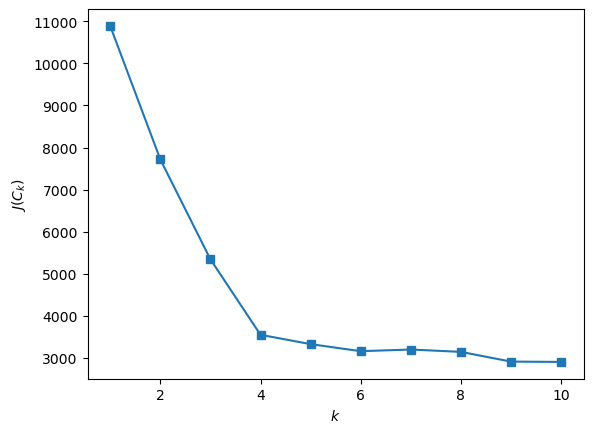

In [19]:
# Список для инерций
inertias = []

# Мы будем проверять от 1 до 10 кластеров
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(packets_vectorised)
    inertias.append(kmeans.inertia_)

# Строим график зависимости инерции от числа кластеров
plt.plot(range(1, 11), inertias, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [20]:
%%time
clusters = KMeans(n_clusters=4).fit(packets_vectorised)

Wall time: 5.05 s


In [21]:
tfidf_metrics = metrics.homogeneity_completeness_v_measure(top5_labels, clusters.labels_)
print(f'Homogeniety: {tfidf_metrics[0]}')
print(f'Completeness: {tfidf_metrics[1]}')
print(f'V_measure: {tfidf_metrics[2]}')

Homogeniety: 0.5865379728459246
Completeness: 0.7902641748323344
V_measure: 0.6733283324703723


Изобразим полученные векторные представления, а также исходные метки, и метки, которые соответствуют полученным кластерам.

Для уменьшения размерности кластеров будем использовать алгоритм **t-sne**.
**t-sne** (t-distributed stochastic neighbor embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных.

In [22]:
def visualize_with_TSNE(X, labels, title, random_state=100):
    n_iter = 1000 #@param {type:"slider", min:250, max:1500, step:25}
    perplexity = 40 #@param {type:"slider", min:5, max:50, step:5}

    tsne = TSNE(n_components=2, verbose=0, 
            perplexity=perplexity, n_iter=n_iter,
            learning_rate = 'auto', init = 'random', random_state=random_state)
    tsne_results = tsne.fit_transform(X)
    x = [i[0] for i in tsne_results]
    y = [i[1] for i in tsne_results]
    dict_lables = dict()
    lab_list = list(set(labels))
    for count, schema in enumerate(lab_list):
            dict_lables[schema] = count
    labs = [dict_lables[i] for i in labels]
    import matplotlib.colors as colors
    colors_list = ['#1E90FF','#00FF7F','#FFFF00','#FF0000','#FFA500','#0000FF','#008000','#FF00FF','#9370DB','#00FFFF', '#FF1493', '#9ACD32','#9932CC','#1effcb']
#     colours = ['r','b','g','c','m','y','k']
    print(lab_list)
    scatter = plt.scatter(x=x, y=y, c = labs, cmap=ListedColormap(colors_list[:len(labs)]))
    plt.legend(handles=scatter.legend_elements()[0], labels=lab_list, loc="upper left")
    plt.title(title)

[0, 1, 4, 5, 9]


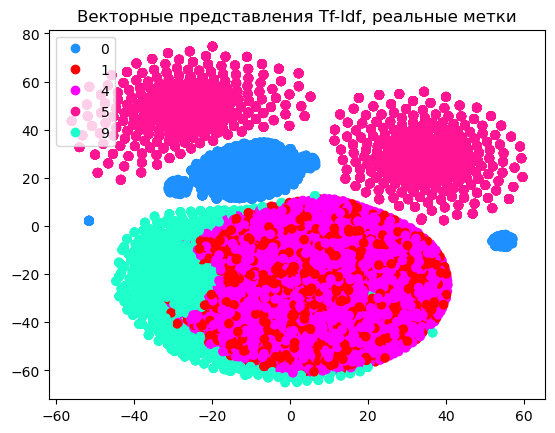

In [23]:
visualize_with_TSNE(packets_vectorised, top5_labels, 'Векторные представления Tf-Idf, реальные метки')

## FastText

fastText – модель машинного обучения для построения векторных представлений слов и одноименная библиотека с открытым исходным кодом для классификации текстов, которая была опубликована в 2015 году исследовательской лабораторией искусственного интеллекта Facebook. Компания также предоставляет модели: English word vectors (предварительно обучена английскому webcrawl и Википедии) и Multi-lingual word vectors (обученные модели для 157 различных языков), которые позволяют создать алгоритмы Supervised и Unsupervised learning для получения векторных представлений слов. 

<img src="fasttext.png" width=400 height=400 />

**Gensim** – это библиотека с открытым исходным кодом на Python, написанная Радимом Рехуреком, которая используется для тематического моделирования без учителя и обработки естественного языка (NLP). Она предназначена для извлечения семантических тем из документов.
Примеры приложений из библиотеки Gensim:
- Создание корпуса из заданного датасета.
- Матрицы TFIDF.
- Создание биграммы и триграммы.
- Модели Word2Vec.
- Модели Doc2Vec.
- Создание тематической модели с LDA (Латентное размещение Дирихле).
- Создание тематической модели с LSI (Латентно-семантическое индексирование).

In [24]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [25]:
splited_gen_packets = [i.split(' ') for i in top5_packets]

In [26]:
%%time
model2 = FastText(vector_size=256, window=1, min_count=1, sentences=splited_gen_packets, epochs=15)
wv = dict(zip(model2.wv.index_to_key , model2.wv.vectors))
packet_ft_1=mean_vectorizer(wv).fit(splited_gen_packets).transform(splited_gen_packets)
packet_ft_1.shape

Wall time: 7.24 s


(27683, 256)

In [27]:
packet_ft_1[0]

array([-0.26795933,  0.22302595,  0.04427125,  0.24190044,  0.17200005,
        0.1919602 , -0.16663666, -0.22017393, -0.00668796, -0.3015332 ,
       -0.06859075, -0.21491091, -0.5310421 ,  0.02495101,  0.03618365,
       -0.42382237,  0.40277007, -0.28498232, -0.37855232, -0.02069174,
        0.30454376, -0.37832427,  0.00615609,  0.31135374, -0.5841263 ,
        0.04108882,  0.21781176, -0.04511445,  0.15095404,  0.07593656,
        0.20105992,  0.13401338,  0.13813631,  0.09431996,  0.3672761 ,
        0.03742587, -0.06416298, -0.07575183, -0.01367002, -0.0139058 ,
       -0.1543951 ,  0.24669525, -0.3116599 ,  0.15547596,  0.12220753,
        0.10328108,  0.252478  ,  0.00949391, -0.4790957 ,  0.19346285,
       -0.32175127,  0.0499901 ,  0.07620942,  0.02913495,  0.15568468,
        0.01289146,  0.01581627, -0.17970999, -0.21842179, -0.08531994,
        0.22275692,  0.40722594,  0.16030753, -0.21562555, -0.25424924,
       -0.2643565 , -0.1837662 ,  0.14710087,  0.12453526,  0.01

In [28]:
%%time
clusters = KMeans(n_clusters=5).fit(packet_ft_1)

Wall time: 2.16 s


In [29]:
ft_metrics = metrics.homogeneity_completeness_v_measure(top5_labels, clusters.labels_)
print(f'Homogeniety: {ft_metrics[0]}')
print(f'Completeness: {ft_metrics[1]}')
print(f'V_measure: {ft_metrics[2]}')

Homogeniety: 0.9124271700135196
Completeness: 0.8772603141283543
V_measure: 0.8944982326555204


[0, 1, 4, 5, 9]


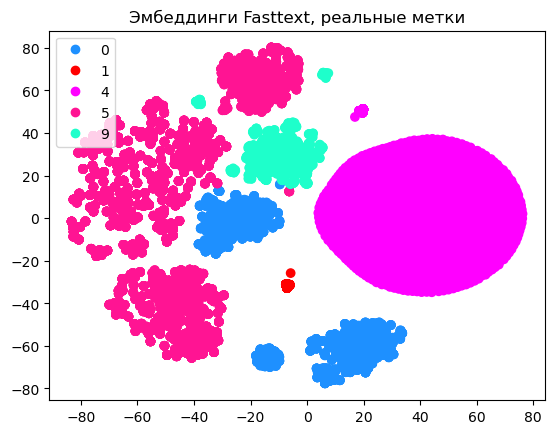

In [30]:
visualize_with_TSNE(packet_ft_1, top5_labels, 'Эмбеддинги Fasttext, реальные метки')

[0, 1, 2, 3, 4]


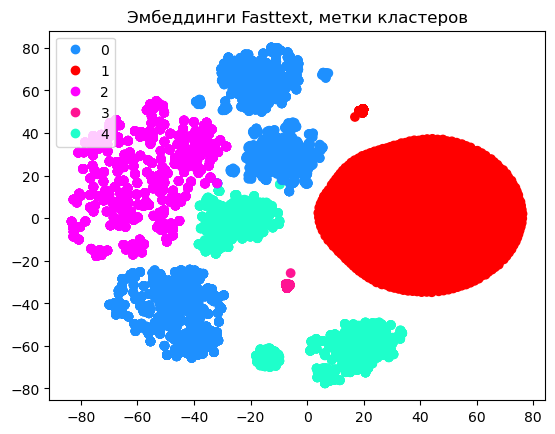

In [34]:
visualize_with_TSNE(packet_ft_1, clusters.labels_, 'Эмбеддинги Fasttext, метки кластеров')

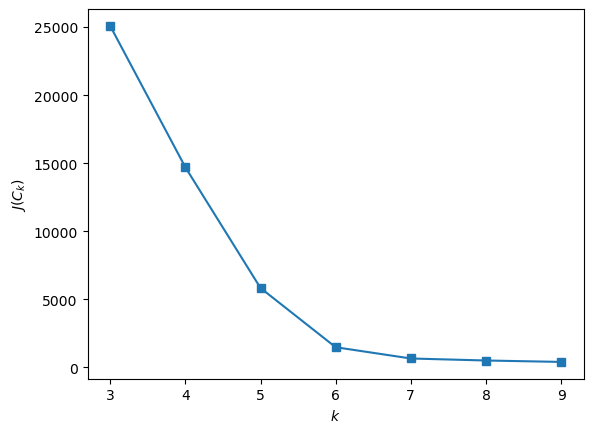

In [43]:
# Список для инерций
inertias = []
# Список для коэффициентов ситуэта
silhouette_scores = []

# Мы будем проверять от 1 до 10 кластеров
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(packet_ft_1)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(metrics.silhouette_score(packet_ft_1, kmeans.labels_))

# Строим график зависимости инерции от числа кластеров
plt.plot(range(3, 10), inertias, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

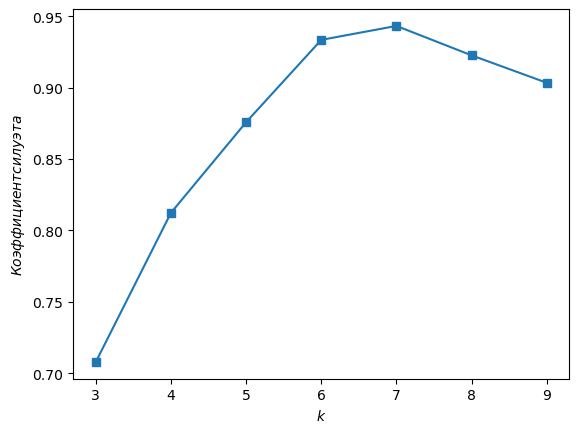

In [44]:
# Строим график зависимости коэффициента силуэта от числа кластеров
plt.plot(range(3, 10), silhouette_scores, marker='s');
plt.xlabel('$k$')
plt.ylabel('$Коэффициент силуэта$');

In [45]:
%%time
clusters = KMeans(n_clusters=7).fit(packet_ft_1)

Wall time: 2.31 s


In [46]:
ft_metrics = metrics.homogeneity_completeness_v_measure(top5_labels, clusters.labels_)
print(f'Homogeniety: {ft_metrics[0]}')
print(f'Completeness: {ft_metrics[1]}')
print(f'V_measure: {ft_metrics[2]}')

Homogeniety: 0.9989811850971264
Completeness: 0.866570514371014
V_measure: 0.9280768146638715
